# Part I

### Задание

1. Загрузите выборку weighted_knn.csv.
2. Реализуйте метод k ближайших соседей. В данной задаче будем использовать метрику Манхэттена:
$$ \rho(u,v)=\sum_{j=1}^{m}|u_j-v_j|.$$
3. Возьмите число соседей равным 5. Какого качества удается достичь на обучающей выборке?
4. Метрические методы довольно чувствительны к шумовым признакам. Исходную метрику можно модифицировать таким образом, чтобы каждый из признаков имел свой вес $\theta_j$:
$$ \rho(u,v)=\sum_{j=1}^{m}\theta_j|u_j-v_j|.$$
5. Реализуйте функцию, которая принимает на вход обучающую выборку `X`, `y`, число соседей `k` и веса признаков `theta`, а возвращает долю неверно классифицированных объектов при заданных параметрах.
6. С помощью функции `minimize` из пакета `scipy` найдите оптимальные значения параметров `theta`. Как изменилось качество классификации?

Буквально недавно (2 дня назад) выполнялась мною домашняя работа в параллельном курсе по Машинному обучению в ozon masters, в котором нужно было реализовать собственный KNN, поэтому мне повезло не тратить на это очень много времени. С реализацией и спефицикацией можно ознакомиться в папке knn.

In [1]:
from knn import KNNClassifier, BatchedKNNClassifier
from knn.distances import euclidean_distance, cosine_distance, manhattan_distance
from knn.model_selection import knn_cross_val_score
from knn.classification import BatchedMixin
from knn.nearest_neighbors import NearestNeighborsFinder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, BaseCrossValidator
from knn.kernels import *

import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# 1 

Загрузите выборку `weighted_knn.csv`.

In [3]:
data = pd.read_csv("weighted_knn.csv")

In [4]:
X = data.drop(columns="target").values
y = data.target.values
X.shape, y.shape

((500, 15), (500,))

In [5]:
n = 400
X_train, y_train, X_test, y_test = X[:n], y[:n], X[n:], y[n:]

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 15), (400,), (100, 15), (100,))

# 2

Реализуйте метод `k` ближайших соседей. В данной задаче будем использовать метрику Манхэттена

In [7]:
metrics = ['euclidean', 'cosine', 'manhattan']
acc_score_result = {v: 0 for v in metrics}

# 3

Возьмите число соседей равным 5. Какого качества удается достичь на обучающей выборке?

In [8]:
for metric in acc_score_result.keys():
    knn_batch = BatchedKNNClassifier(n_neighbors=5, algorithm='my_own', metric=metric, W=False)
    knn_batch.set_batch_size(10)
    knn_batch.fit(X_train, y_train)
    y_pred = knn_batch.predict(X_test)
    acc_score_result[metric] = accuracy_score(y_pred, y_test)

In [9]:
acc_score_result

{'euclidean': 0.88, 'cosine': 0.88, 'manhattan': 0.91}

**Ответ**: 0.91

## 3.1 Кросс-валидация

In [10]:
k_list = np.arange(1, 11)
acc_score_cross_validation = {v: 0 for v in metrics}

In [11]:
for metric in acc_score_cross_validation.keys():
    print(f'Metric: {metric}')
    res = knn_cross_val_score(X, y, 
                              k_list=k_list,
                              scoring='accuracy',
                              cv=KFold(n_splits=10),
                              batch_size=1,
                              algorithm='my_own',
                              metric=metric)
    acc_score_cross_validation[metric] = res

Metric: euclidean
Metric: cosine
Metric: manhattan


In [12]:
cross_validation_result_accuracy_mean = {k: {r: np.mean(f) for r, f in acc.items()} for k, acc in acc_score_cross_validation.items()}

In [13]:
df_cross_validation_result_accuracy_mean = pd.DataFrame(cross_validation_result_accuracy_mean)
df_cross_validation_result_accuracy_mean

euclidean  cosine  manhattan
1       0.842   0.846      0.868
2       0.800   0.834      0.840
3       0.870   0.868      0.898
4       0.866   0.866      0.888
5       0.866   0.876      0.898
6       0.858   0.882      0.894
7       0.886   0.892      0.914
8       0.870   0.880      0.906
9       0.892   0.888      0.916
10      0.878   0.888      0.906

## 4. 

Метрические методы довольно чувствительны к шумовым признакам. Исходную метрику можно модифицировать таким образом, чтобы каждый из признаков имел свой вес $\theta_j$:
$$ \rho(u,v)=\sum_{j=1}^{m}\theta_j|u_j-v_j|.$$

Добавим `W = np.ndarray размерности D, где D - количество признаков`

In [14]:
d = np.ones(15)
assert d.shape[0] == X_train.shape[1]

In [15]:
d = np.array([100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
d.shape
knn_batch = BatchedKNNClassifier(n_neighbors=5, algorithm='my_own', metric='manhattan', W=d)
knn_batch.set_batch_size(10)
knn_batch.fit(X_train, y_train)
y_pred = knn_batch.predict(X_test)
accuracy_score(y_pred, y_test)

0.91

# 5. 

Реализуйте функцию, которая принимает на вход обучающую выборку `X`, `y`, число соседей `k` и веса признаков `theta`, а возвращает долю неверно классифицированных объектов при заданных параметрах.

In [16]:
def get_test_error(w):
    knn_batch = BatchedKNNClassifier(n_neighbors=5, algorithm='my_own', metric='manhattan', 
                                     W = w)
    knn_batch.set_batch_size(10)
    knn_batch.fit(X_train, y_train)
    y_pred = knn_batch.predict(X_test)
    return 1 - accuracy_score(y_pred, y_test)

# 6

С помощью функции `minimize` из пакета `scipy` найдите оптимальные значения параметров `theta`. Как изменилось качество классификации?

In [17]:
res = scipy.optimize.minimize(get_test_error, x0=np.zeros(X_train.shape[1]))
res.x

array([ 3.35948153e-05,  2.55960498e-05,  5.59913589e-06,  2.39962967e-06,
        2.55960498e-05,  3.99938278e-06,  3.99938278e-06,  6.39901245e-06,
        7.99876556e-07,  1.59975311e-06, -3.19950622e-06,  7.99876556e-07,
        7.99876556e-06,  0.00000000e+00,  0.00000000e+00])

In [18]:
get_test_error(res.x)

0.07999999999999996

# Part II

В качестве модельных данных возьмите точки их двух двумерных нормальных распределений с разными математическими ожиданиями.

Сгенерируйте обучающую и тестовую выборку для каждого из случаев.

Количество объектов в обучающей выборке первого класса - $n_1$, второго - $n_2$. Для тестирования возьмите ещё по 20 объектов каждого из классов.

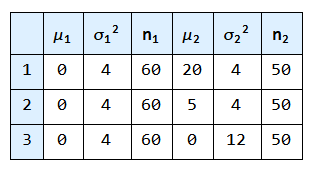

## First

In [19]:
seed = np.random.RandomState(2789)
train_11 = seed.normal(0, np.sqrt(4), (60, 2))
test_11 = seed.normal(0, np.sqrt(4), (20, 2))
train_12 = seed.normal(20, np.sqrt(4), (50, 2))
test_12 = seed.normal(20, np.sqrt(4), (20, 2))

In [20]:
train_1 = np.concatenate((train_11, train_12), axis = 0)
test_1 = np.concatenate((test_11, test_12), axis = 0)
y_train = np.concatenate((np.full(60, 1), np.full(50, 0)))
y_test = np.concatenate((np.full(20, 1), np.full(20, 0)))

In [21]:
train_1.shape, test_1.shape

((110, 2), (40, 2))

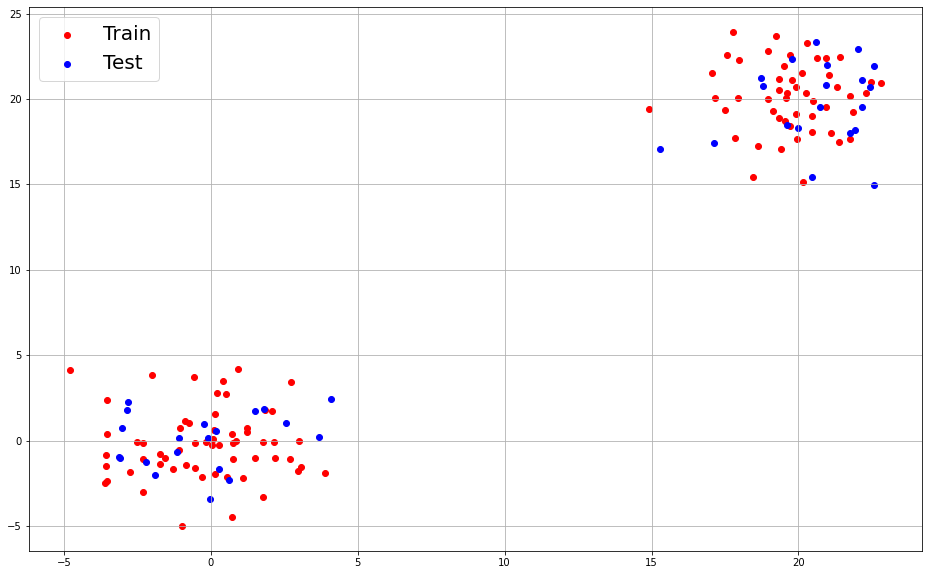

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.scatter(train_1[:, 0], train_1[:, 1], color = 'red', label='Train')
ax.scatter(test_1[:, 0], test_1[:, 1], color = 'blue', label='Test')
ax.legend(fontsize=20)
ax.grid()
plt.show()

## Second

In [23]:
seed = np.random.RandomState(2789)
train_21 = seed.normal(0, np.sqrt(4), (60, 2))
test_21 = seed.normal(0, np.sqrt(4), (20, 2))
train_22 = seed.normal(5, np.sqrt(4), (50, 2))
test_22 = seed.normal(5, np.sqrt(4), (20, 2))

In [24]:
train_2 = np.concatenate((train_21, train_22), axis = 0)
test_2 = np.concatenate((test_21, test_22), axis = 0)

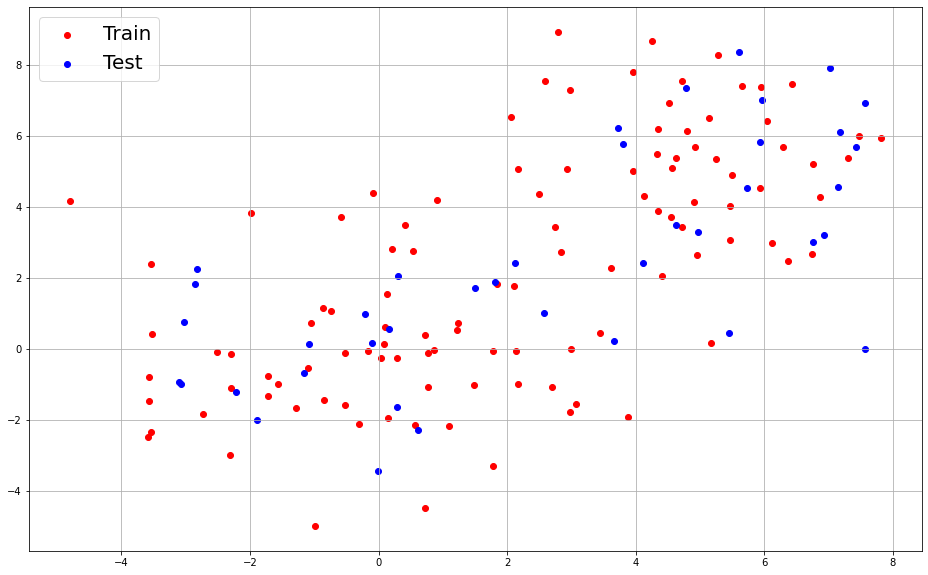

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.scatter(train_2[:, 0], train_2[:, 1], color = 'red', label='Train')
ax.scatter(test_2[:, 0], test_2[:, 1], color = 'blue', label='Test')
ax.legend(fontsize=20)
ax.grid()
plt.show()

## Third

In [26]:
seed = np.random.RandomState(2789)
train_31 = seed.normal(0, np.sqrt(4), (60, 2))
test_31 = seed.normal(0, np.sqrt(4), (20, 2))
train_32 = seed.normal(0, np.sqrt(12), (50, 2))
test_32 = seed.normal(0, np.sqrt(12), (20, 2))

In [27]:
train_3 = np.concatenate((train_31, train_32), axis = 0)
test_3 = np.concatenate((test_31, test_32), axis = 0)

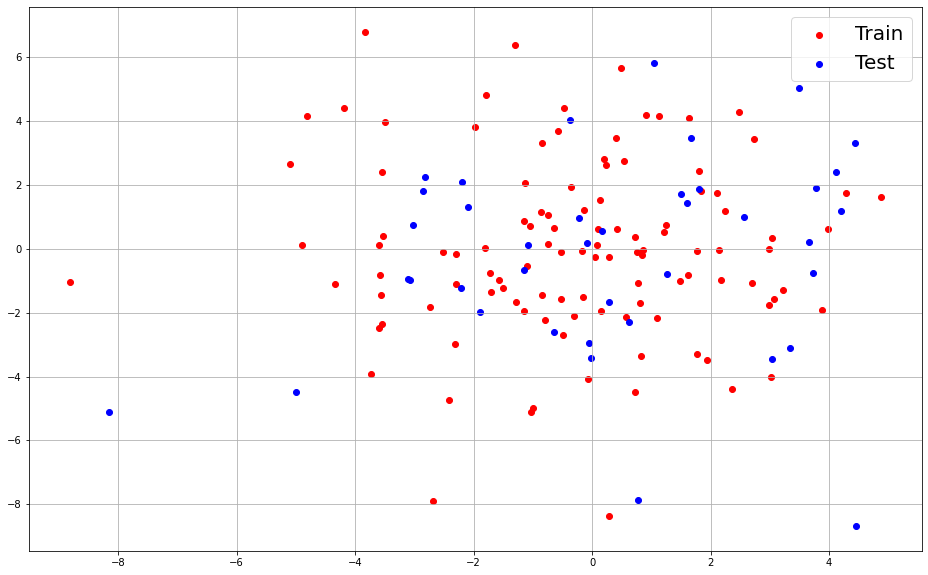

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.scatter(train_3[:, 0], train_3[:, 1], color = 'red', label='Train')
ax.scatter(test_3[:, 0], test_3[:, 1], color = 'blue', label='Test')
ax.legend(fontsize=20)
ax.grid()
plt.show()

## Выбор числа соседей

In [29]:
d = {1: (train_1, test_1),
     2: (train_2, test_3),
     3: (train_3, test_3)
    }
k_neighbors = range(1, 15, 2)
acc_score_result_k = {me : {k: 0 for k in k_neighbors} for me in d.keys()}
acc_score_result_k

{1: {1: 0, 3: 0, 5: 0, 7: 0, 9: 0, 11: 0, 13: 0},
 2: {1: 0, 3: 0, 5: 0, 7: 0, 9: 0, 11: 0, 13: 0},
 3: {1: 0, 3: 0, 5: 0, 7: 0, 9: 0, 11: 0, 13: 0}}

In [30]:
for m in d.keys():
    X_train, X_test = d[m]
    for k in acc_score_result_k[m].keys():
        knn_batch = BatchedKNNClassifier(n_neighbors=k, algorithm='my_own', metric='euclidean', W=False)
        knn_batch.set_batch_size(1)
        knn_batch.fit(X_train, y_train)
        y_pred = knn_batch.predict(X_test)
        acc_score_result_k[m][k] = accuracy_score(y_pred, y_test)

In [31]:
acc_score_result_k

{1: {1: 1.0, 3: 1.0, 5: 1.0, 7: 1.0, 9: 1.0, 11: 1.0, 13: 1.0},
 2: {1: 0.575, 3: 0.575, 5: 0.6, 7: 0.6, 9: 0.6, 11: 0.6, 13: 0.6},
 3: {1: 0.8, 3: 0.75, 5: 0.725, 7: 0.65, 9: 0.675, 11: 0.675, 13: 0.725}}

In [32]:
result = pd.DataFrame(acc_score_result_k)
result

1      2      3
1   1.0  0.575  0.800
3   1.0  0.575  0.750
5   1.0  0.600  0.725
7   1.0  0.600  0.650
9   1.0  0.600  0.675
11  1.0  0.600  0.675
13  1.0  0.600  0.725

**Вывод**: для первой выборки абсолютная точность - не удивительно, ведь кластеры расположены далеко друг от друга. Для второй выборки разделение происходит с точностью наивного алгоритма - точки смешаны и нет выделенных кластеров. В третьем случае `accuracy` лучше, когда мы предсказываем класс по классу ближайшего соседа.

## Метод Парзеновского окна

Рассмотрим различные функции ядра $K(z)$.

Решение методом Парзеновского окна ищется в виде:

$$a(x) = \underset{y \in Y}{\operatorname{argmax}}\sum\limits_{i=1}^l [y_u = y]K\left(\frac{\rho(x, x_i)}{h}\right)$$

При следующих [ядрах](https://en.wikipedia.org/wiki/Kernel_(statistics)):

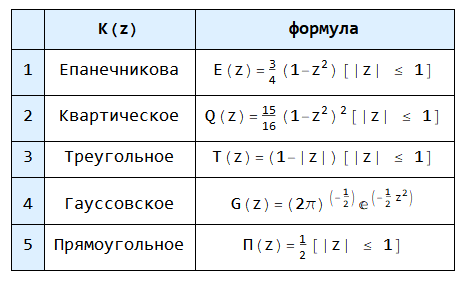

где $K(z)$ - функция ядра, $\rho(x, x_i)$ - расстояние между классифицируемым объектом и объектом выборки, а $h$ - ширина окна.

In [33]:
kernels = ['epanechnikov', 'quartic', 'triangular', 'gaussian', 'uniform']
methods = [epanechnikov_kernel, quartic_kernel, triangular_kernel, gaussian_kernel, uniform_kernel]

In [34]:
arr = np.linspace(-3, 3, 1000)

In [35]:
ker = dict(zip(kernels, methods))

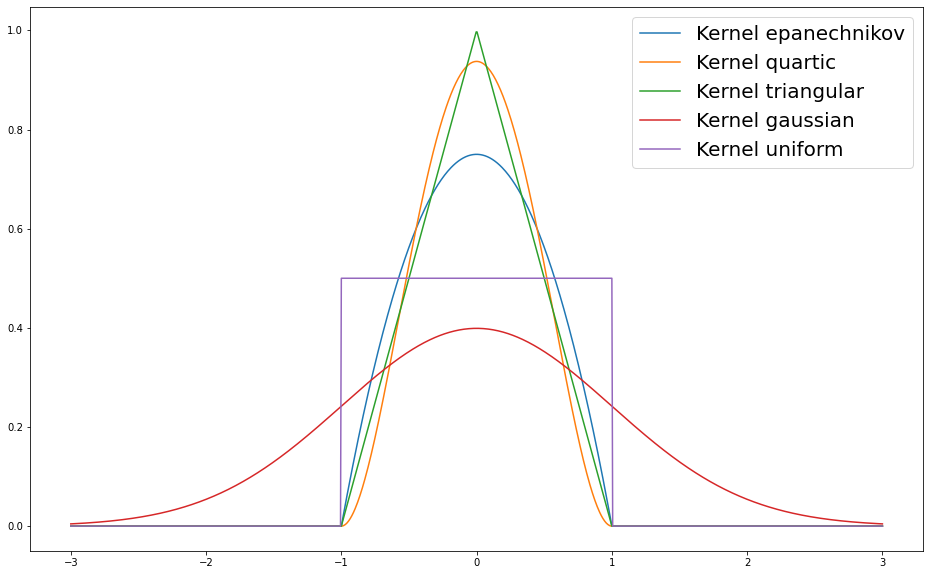

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
for kernel, function in ker.items():
    values = function(arr)
    ax.plot(arr, values, label=f'Kernel {kernel}')

ax.legend(fontsize=20)
plt.show()

## 4

По исходным данным выберите ширину окна. Постройте классификаторы со всеми перечисленными функциями ядра.  Проведите эксперименты для каждого из случаев и укажите среднее качество. Сделайте выводы.

## Fixed k

In [37]:
d = {1: (train_1, test_1),
     2: (train_2, test_3),
     3: (train_3, test_3)
    }
h_neighbors = np.linspace(0.5, 5, 10)
acc_score_result_k = {me : {k: {kernel: 0 for kernel in kernels} for k in h_neighbors} for me in d.keys()}
acc_score_result_k[1]

{0.5: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 1.0: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 1.5: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 2.0: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 2.5: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 3.0: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 3.5: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 4.0: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 4.5: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0},
 5.0: {'epanechnikov': 0,
  'quartic': 0,
  'triangular': 0,
  'gaussian': 0,
  'uniform': 0}}

In [38]:
for m in d.keys():
    X_train, X_test = d[m]
    for h in acc_score_result_k[m].keys():
        for kernel in acc_score_result_k[m][h].keys():
            knn_batch = BatchedKNNClassifier(n_neighbors=5, 
                                             algorithm='my_own',
                                             weights ='kernel',
                                             metric='euclidean',
                                             W=False, 
                                             h=h, 
                                             kernel=kernel)
            knn_batch.set_batch_size(1)
            knn_batch.fit(X_train, y_train)
            y_pred = knn_batch.predict(X_test)
            acc_score_result_k[m][h][kernel] = accuracy_score(y_pred, y_test)

In [39]:
result_kernels_1 = pd.DataFrame(acc_score_result_k[1])
result_kernels_1

0.5   1.0    1.5  2.0  2.5  3.0  3.5  4.0  4.5  5.0
epanechnikov  0.75  0.95  0.975  1.0  1.0  1.0  1.0  1.0  1.0  1.0
quartic       0.75  0.95  0.975  1.0  1.0  1.0  1.0  1.0  1.0  1.0
triangular    0.75  0.95  0.975  1.0  1.0  1.0  1.0  1.0  1.0  1.0
gaussian      1.00  1.00  1.000  1.0  1.0  1.0  1.0  1.0  1.0  1.0
uniform       0.75  0.95  0.975  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [40]:
result_kernels_2 = pd.DataFrame(acc_score_result_k[2])
result_kernels_2

0.5  1.0    1.5    2.0    2.5    3.0   3.5   4.0   4.5   5.0
epanechnikov  0.675  0.8  0.675  0.700  0.675  0.675  0.65  0.65  0.65  0.65
quartic       0.675  0.8  0.675  0.675  0.675  0.675  0.65  0.65  0.65  0.65
triangular    0.675  0.8  0.675  0.675  0.675  0.675  0.65  0.65  0.65  0.65
gaussian      0.575  0.6  0.600  0.600  0.600  0.600  0.60  0.60  0.60  0.60
uniform       0.700  0.8  0.675  0.700  0.675  0.675  0.65  0.65  0.65  0.65

In [41]:
result_kernels_3 = pd.DataFrame(acc_score_result_k[3])
result_kernels_3

0.5   1.0    1.5    2.0    2.5    3.0    3.5    4.0    4.5  \
epanechnikov  0.675  0.85  0.775  0.750  0.750  0.750  0.750  0.725  0.725   
quartic       0.675  0.85  0.825  0.775  0.750  0.750  0.750  0.750  0.750   
triangular    0.675  0.85  0.775  0.775  0.750  0.750  0.750  0.750  0.725   
gaussian      0.825  0.75  0.750  0.750  0.725  0.725  0.725  0.725  0.725   
uniform       0.675  0.80  0.800  0.750  0.750  0.750  0.725  0.725  0.725   

                5.0  
epanechnikov  0.725  
quartic       0.725  
triangular    0.725  
gaussian      0.725  
uniform       0.725

## Fixed k

In [42]:
d = {1: (train_1, test_1),
     2: (train_2, test_3),
     3: (train_3, test_3)
    }
k_neighbors = range(1, 15, 2)
acc_score_result_k = {me : {k: {kernel: 0 for kernel in kernels} for k in k_neighbors} for me in d.keys()}

In [43]:
for m in d.keys():
    X_train, X_test = d[m]
    for k in acc_score_result_k[m].keys():
        for kernel in acc_score_result_k[m][k].keys():
            knn_batch = BatchedKNNClassifier(n_neighbors=k, 
                                             algorithm='my_own',
                                             weights ='kernel',
                                             metric='euclidean',
                                             W=False, 
                                             h=1, 
                                             kernel=kernel)
            knn_batch.set_batch_size(1)
            knn_batch.fit(X_train, y_train)
            y_pred = knn_batch.predict(X_test)
            acc_score_result_k[m][k][kernel] = accuracy_score(y_pred, y_test)

In [44]:
result_kernels_1 = pd.DataFrame(acc_score_result_k[1])
result_kernels_1

1     3     5     7     9     11    13
epanechnikov  0.95  0.95  0.95  0.95  0.95  0.95  0.95
quartic       0.95  0.95  0.95  0.95  0.95  0.95  0.95
triangular    0.95  0.95  0.95  0.95  0.95  0.95  0.95
gaussian      1.00  1.00  1.00  1.00  1.00  1.00  1.00
uniform       0.95  0.95  0.95  0.95  0.95  0.95  0.95

In [45]:
result_kernels_2 = pd.DataFrame(acc_score_result_k[2])
result_kernels_2

1      3    5    7    9    11   13
epanechnikov  0.800  0.800  0.8  0.8  0.8  0.8  0.8
quartic       0.800  0.800  0.8  0.8  0.8  0.8  0.8
triangular    0.800  0.800  0.8  0.8  0.8  0.8  0.8
gaussian      0.575  0.575  0.6  0.6  0.6  0.6  0.6
uniform       0.800  0.800  0.8  0.8  0.8  0.8  0.8

In [46]:
result_kernels_3 = pd.DataFrame(acc_score_result_k[3])
result_kernels_3

1      3     5      7      9      11     13
epanechnikov  0.8  0.825  0.85  0.825  0.825  0.825  0.825
quartic       0.8  0.825  0.85  0.825  0.825  0.825  0.825
triangular    0.8  0.825  0.85  0.825  0.825  0.825  0.825
gaussian      0.8  0.775  0.75  0.725  0.750  0.750  0.725
uniform       0.8  0.825  0.80  0.775  0.800  0.800  0.775

**Выводы**: можно сделать вывод, что с помощью различных ядер для различных задач можно подобрать параметры, при котороых качество классификации будет увеличиваться. Так в третьей выборке мы смогли подобрать такое ядро (`epanechnikov`), такое количество ближайших соседей `k=5` и ширину окна `h=1`, чтобы при данных параметрах классификация улучшилась до `0.85`, а во втором случае - до `0.8`. Также можно сделать вывод, что ядро Гаусса работает лучше для разделимой выборки.